# Assignment 3 - Partial Differential Equations

In this assignment, you will find numerical solutions to partial differential equations.  In particular, you will use an implicit method for solving the diffusion equation, considering problems with both Dirichlet and Neumann boundary conditions.

In each part of this assignment, you will be asked to write some code in the cell indicated.  If you find it convenient to break your code up over multiple cells, please do so.  You will also be asked to discuss your code and results obtained in a text cell.

You should use numpy and scipy libraries where appropriate. You will always be told explicitly if you should **not** use a particular library.  Make sure to comment your code.  Make sure all cells run from a freshly started notebook before you submit your work.

## The Diffusion Equation

In this assignment, you will find numerical solutions to the diffusion equation.

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
}$$

$$b = \pmatrix{
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

Your code should construct the matrix equation including boundary value term, and solve it using an appropriate linear algebra routine from scipy. You should verify your results, and quantify the uncertainties due to the method.  Discuss your results in the cell below.

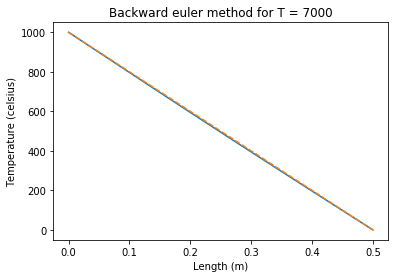

In [15]:
'''
The following naming convention of variables are used.
===== ==========================================================
Name  Description
===== ==========================================================
Nx    The total number of mesh cells; mesh points are numbered
      from 0 to Nx.
a     The dimensionless number k*dt/dx**2, which implicitly
      specifies the time step.
T     The stop time for the simulation.
k     thermal difusivity.
C     Specific heat capacity
Th    Thermal conductivity
L     Length of the domain ([0,L]).
x     Mesh points in space.
u     Unknown at current/new time level.
u_n   u at the previous time level.
dx    Constant mesh spacing in x.
dt    Constant mesh spacing in t.
===== ==========================================================
'''


import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

#Defines the thermal equilibirum for the direchlet conditions
def Dirichlet_Thermal_equilibrium(x,d_0=1000,d_N=0,L=0.5):
    return (d_N-d_0)/L * x + d_0

#Sets up all of the values required for the implicit method
def setup(dt=1,L=0.5,dx=0.005):
    
    Nx = int(round(L/dx))
    x = np.linspace(0,L,Nx)
    
    #alpha calculation
    Th = 59
    C = 450
    p = 7900

    k = Th/(p*C)
    a = (dt*k)/dx**2
    
    #u_n is the initial state of the middle of the bar at t=0
    u_n = np.full(Nx-2, 20, dtype=np.int)
    
    #Setting up the matrix equation
    M = np.zeros((Nx-2,Nx-2))
    b = np.zeros(Nx-2)
    
    return M, b, u_n, Nx, a, x, dt
    

#The function for the backward euler method
def BE_method(T,cond,dt=1,d_0=1000,d_N=0):
    
    M, b, u_n, Nx, a, x, dt = setup()

    #Fills in the M matrix
    np.fill_diagonal(M, 1+2*a)
    np.fill_diagonal(M[1:], -a)
    np.fill_diagonal(M[:,1:], -a)
    
    #fills in the b matrix
    b[0] = -a * d_0
    
    #the cond value defines whether theres a dirichlet condition or the neumann condition , 0 = Dirichlet and 1 = Neumann 
    if cond == 0:
        
        b[Nx-3] = -a * d_N
    
    elif cond == 1:
        np.put(M,[(Nx-2)**2 -1],1+a)
    
    #Matrix needed to be inverted
    M_1 = np.linalg.inv(M)
    
    #This while loop calculates the equation u = M_1(u_n-b) up to the given time
    t_count = 0
    while t_count <= T:
        z = u_n - b 
        u = np.matmul(M_1,z)
        u_n = u
        t_count = t_count + dt
    
    #This last part appends the boundary conditions to the code

    u_b = np.insert(u,0,d_0)
    
    
    if cond ==0:
        u_e = np.insert(u_b,len(u_b),d_N)
        
    elif cond ==1:
         u_e = np.insert(u_b,len(u_b),u_b[len(u_b)-1])
        
    return u_e, x, T


u_e, x, T = BE_method(7000,0)


#Plots the result with the therm equilibrium    
plt.plot(x,u_e)
plt.ylabel("Temperature (celsius)")
plt.xlabel("Length (m)")
plt.title("Backward euler method for T = " +str(T))
    
plt.plot(x,Dirichlet_Thermal_equilibrium(x), linestyle='dashed')
plt.show()
    

    





**To solve the diffusion equation, a implicit method is best due to its stability for alpha values larger than 0.5 [1]. The backward euler method is an implicit method that has been implemented to solve the diffusion equation. The code above does this by creating an matrix equation:**

**u = M^-1(u-b)**

**and repeats this for T/dt amount of times to get the final temperature graph of the metal bar. The results from the graphs at different time show that at low times, the part of the bar that is closest to the heated end heats up and as time progresses, this heats goes along the bar and causes a linear heat length relation, this occurs around 7000 seconds.**   



**[1] Finite difference computing with PDEs - A Modern Software Approach, Hans petter Langtangen & Svein Linge, Center for Biomedical Computing, Simula Research Laboratory**


## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two noces have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \pmatrix{
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

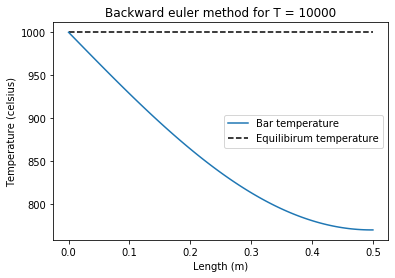

In [16]:
#BE_method implemented but instead cond =1 which means that the neumann boundary is set
u_e, x, T = BE_method(10000,1)

plt.plot(x,u_e,label="Bar temperature")
plt.ylabel("Temperature (celsius)")
plt.xlabel("Length (m)")
plt.title("Backward euler method for T = " +str(T))

#The thermal equilibrium is set as a straight line corresponding to a consatnt temperature of d_0 across the bar
plt.hlines(1000,0,0.5,linestyle='dashed',label="Equilibirum temperature")
plt.legend(loc="center right")
plt.show()




**Use this cell to discuss your code & results**

**The code from the first section is set up to allow the conditions to be changed from Dirichlet boundaries to the Neumann boundaries. The problem itself still needs a dirichlet boundary condition as one of the ends of the rod is kept at 1000 degrees celsius whereas the other end is insulated. The matrix problem is also the same but isntead with some tweaks to the matrix M to enforce the Neumann boundary and the matrix b being changed to just having one non-zero term. **

**The results are to be expected with the rod eventually reaching an equilibrium value which will be a bar of constant temperature equal to d_0 (1000 degrees celsius).